In [1]:
import pdal
import glob
import io
import ipyleaflet
import IPython.display
import ipyvolume.pylab as p3
import matplotlib.cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely.geometry
import scipy.spatial
import pyproj
import open3d as o3d

import os
import requests
import json
import sys
import urllib.request


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
LC_laz = '/home/jose/Desktop/LiDAR_nmsu/SouthEastB1/points.laz'

# Computing pointcloud + Meshes ( Do not run cells if meshes are already calculated )

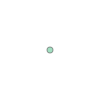

In [3]:
# generating a sampling point using shapley geometry objects
point = shapely.geometry.Point([-106.575331, 32.35488])   # these are WGS/UTM13 coordinate
point

In [4]:
# Changing directory to where liDAR .las file lives in
os.chdir('/home/jose/Desktop/LiDAR_nmsu/SouthEastB1')
os.listdir()  # uses python library os to list all files in the current directory. Just a nice check!

['TEST.ply',
 'isosurface_tri.ply',
 'shape.geojson',
 'point.geojson',
 'shape.qmd',
 'points.laz',
 'points.las',
 'for_open3d.las',
 'isosurf.json',
 'output.tin.tar.gz']

In [ ]:
"""
The following cells contain json objects aka {[...stuff...]}
Just for explanation sake the json.dumps() are just python-type strings! :)

The reason we need to do this is because we use the Pointcloud Data Abstraction Library (PDAL) which is really a
C C++ library. we simply use a python binding in order to use it!

We benefit from all of the efficieny and power of C and C++ within a python or shell environment without all of the
cryptic syntax! or insane programming skills required to code in these lower level programing languages. :)

Anyways... this is why we use json scripts / objects!
"""

In [9]:
# This json script will execute pdal decompression pipeline
decompress = {
    "pipeline": [ LC_laz,
        
      
                 
        {
            "type": "writers.las",
            "filename":"./points.las",
            
        },
        
        
    ]}
pipeline = pdal.Pipeline(json.dumps(decompress))
pipeline.validate()
%time n_points = pipeline.execute()
print('Pipeline selected {} points ({:.1f} pts/m2)'.format(n_points, n_points))

CPU times: user 1min 7s, sys: 3.1 s, total: 1min 10s
Wall time: 1min 9s
Pipeline selected 95161968 points (95161968.0 pts/m2)


In [5]:
# now that our liDAR data is decompressed(.las = uncompressed,   .laz = compressed)
# we can now make a variable with the path to the .las file
LC_las = '/home/jose/Desktop/LiDAR_nmsu/SouthEastB1/points.las'



In [6]:
# now we select what we want ! ! !
cropper = {
    "pipeline": [ LC_las,
        
        # Cropping out all points that lie 400 units from point.wkt
        {   "type":"filters.crop",
             "a_srs": "EPSG:4326",
             "point":point.wkt,
             "distance": 400
        },
          
                 
        {   "type":"filters.eigenvalues",
            "knn":16},
                 # computing normal X,Y,Z components of planes generated by 16 nn. (Also calculates curvature)
        {   "type":"filters.normal",
            "knn":16},
                 
        {
            "type": "writers.las",
            "filename":"for_open3d.las",  # writing a new file with selected points!
            
        },
        
        
    ]}
pipeline = pdal.Pipeline(json.dumps(cropper))
pipeline.validate()
%time n_points = pipeline.execute()
print('Pipeline selected {} points ({:.1f} pts/m2)'.format(n_points, n_points))

CPU times: user 34.1 s, sys: 3.12 s, total: 37.2 s
Wall time: 37.5 s
Pipeline selected 1164109 points (1164109.0 pts/m2)


In [ ]:
"""
Now that we have loaded the point cloud data into memory,
we will now generate arrays to mess around with the data in a more "familiar" python environment
"""

In [7]:
#creating numpy and pandas objects from pdal pipeline above
arr = pipeline.arrays[0]
description = arr.dtype.descr
cols = [col for col, __ in description]
df = pd.DataFrame({col: arr[col] for col in cols})

# making copies of original XYZ coordinates for manipulation down below
df['X_0'] = df['X']
df['Y_0'] = df['Y']
df['Z_0'] = df['Z']

# Centers data around zero instead of geographical coordinates
df['X'] = df['X'] - df['X_0'].min()
df['Y'] = df['Y'] - df['Y_0'].min()
df['Z'] = df['Z'] - df['Z_0'].min()

In [2]:
# we vizualize the data as a pandas dataframe
df.columns#['']


NameError: name 'df' is not defined

In [ ]:
'''
Generating a pcd object from .las data stored in pandas df object 

This is only necessary if we want to use any other features derrived from .las files

example: df['Curvature']

This is because .las and .laz writers do not directly support writing attributes other than
X 	Y 	Z 	Intensity 	ReturnNumber 	NumberOfReturns 	ScanDirectionFlag 	EdgeOfFlightLine 	Classification 	ScanAngleRank
(instead they write external .vrt files and these are not very straight forward...)

'''


In [54]:
# Not necessary to make PCD but nice to have the code to do so
array = np.asarray(df[["X","Y","Z"]])   # must 3 features! so if you would like to see other features ("Curvature") just make extra np arrays

pcd = o3d.geometry.PointCloud() #generates o3d geometry object type PointCloud
pcd.points = o3d.utility.Vector3dVector(array) # adding points from newly made np array
o3d.io.write_point_cloud("./TEST.ply", pcd)  # writes "new" point cloud data as a .ply file  (note its not a .las or .laz!!! same deal just different. Each have pros and cons!)


True

In [56]:
pcd_load = o3d.io.read_point_cloud("/home/jose/Desktop/LiDAR_nmsu/SouthEastB1/TEST.ply") # here we load newly generated .ply point cloud data into memory
o3d.visualization.draw_geometries([pcd_load]) #Lets take a look at our new point cloud file

In [3]:
'''
Loading in mesh... PDAL has the option to generate meshes using a pipeline. We will now load this mesh which was
generated using a delaunay triangulation algorithim.

We are doing this to see the differences between meshes computed using a pdal.Pipeline vs Open3d in house
mesh computations ;) each have pros and cons!

'''

'\nLoading in mesh... PDAL has the option to generate meshes using a pipeline. We will now load this mesh which was\n\n'

In [15]:
mesh = o3d.io.read_triangle_mesh("/home/jose/Desktop/LiDAR_nmsu/SouthEastB1/isosurface_tri.ply",print_progress=True) #loads into memory a .ply triangle mesh file
o3d.visualization.draw_geometries([mesh]) # lets check it out!

In [16]:
# lets look at the data for the PDAL computed mesh.
print('These are the vertices!!!')
print(np.asarray(mesh.vertices))
print()
print('These are the triangle faces!!!')
print(np.asarray(mesh.triangles))



These are the vertices!!!
[[3.51969e+05 3.58105e+06 2.40876e+03]
 [3.51972e+05 3.58105e+06 2.40882e+03]
 [3.51972e+05 3.58105e+06 2.40836e+03]
 ...
 [3.51445e+05 3.58110e+06 2.15335e+03]
 [3.51446e+05 3.58110e+06 2.15344e+03]
 [3.51446e+05 3.58110e+06 2.15351e+03]]

These are the triangle faces!!!
[[ 539739  539690  539691]
 [ 539739  539689  539690]
 [ 539739  545991  539689]
 ...
 [1050201 1050346 1050044]
 [1050044 1050346 1049757]
 [1049757 1050346 1049310]]


*** NOTE: PDAL allows you to compute normals during pipeline for .las... ###

However...

Not for the commandline pipeline of a isosurface.ply file...
So... untill you can find a way to stream line python + comandline in PDAL. This is the only way to compute normals
of a mesh. intother words... untill you get scipy.spatial.Delaunay() to play well with open3d...

In [17]:
print("Does mesh have normals? (exist: " + str(mesh.has_vertex_normals())+').... :(')


Does mesh have normals? (exist: False).... :(


In [18]:
mesh.compute_vertex_normals() # computing normals

TriangleMesh with 1164109 points and 2327726 triangles.

In [19]:
print("How about now? (normals exist: " + str(mesh.has_vertex_normals())+').... :)')

How about now? (normals exist: True).... :)


In [20]:
o3d.visualization.draw_geometries([mesh]) # now that we have performed normal computations lets check it out!

In [21]:
# PAINTING STUFF!!!
print("Painting the mesh")
mesh.paint_uniform_color([0.55, .15, 0.2])
o3d.visualization.draw_geometries([mesh])


Painting the mesh


In [ ]:
'''
Average Mesh Filtering:
We will now take the mesh and smooth it out using averages. each number of iterations will smooth the image more
at the expense of computational resources.

'''

In [22]:
# making a copy of original mesh to mess around with it
import copy
mesh1 = copy.deepcopy(mesh)

In [23]:
# 1 iteration
print('filter with average with 1 iteration')
mesh_out = mesh1.filter_smooth_simple(number_of_iterations=1)
mesh_out.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_out])

filter with average with 1 iteration


In [63]:
# 5 iterations
print('filter with average with 5 iterations')
mesh_out = mesh1.filter_smooth_simple(number_of_iterations=5)
mesh_out.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_out])



filter with average with 5 iterations


In [4]:
# Now lets check it out using wireframs!!!
o3d.visualization.draw_geometries([mesh_out],mesh_show_wireframe=True)

NameError: name 'mesh_out' is not defined

In [ ]:
"""
Decimation: 

Sometimes its possible to simplify a mesh by decimating it. This might be a possible solution to long runtimes
or if regularization is needed
"""

In [56]:
mesh_smp = mesh1.simplify_quadric_decimation(target_number_of_triangles=2100000) # set number of triangles you would like
o3d.visualization.draw_geometries([mesh_smp],mesh_show_wireframe=True)

In [58]:
# smooth out the new surface using an average filter
print('filter with average with 1 iterations')
mesh_out = mesh_smp.filter_smooth_simple(number_of_iterations=5)
mesh_smp.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_out])

filter with average with 1 iterations


In [60]:
o3d.visualization.draw_geometries([mesh_out],mesh_show_wireframe=True)

# Trying scipy delaunay (ignore!!!)

In [45]:
df['ground'] = df['Classification']==2

ground_delaunay = scipy.spatial.Delaunay(df.loc[df['ground'],['X','Y']])
ground_surf = p3.plot_trisurf(df.loc[df['ground'],'Y'], df.loc[df['ground'],'Z'], df.loc[df['ground'],'X'], ground_delaunay.simplices, color='blue')

In [43]:
ma = o3d.utility.Vector3dVector(ground_delaunay.simplices)

In [32]:
ma.compute_vertex_normals()

AttributeError: 'open3d.cpu.pybind.utility.Vector3dVector' object has no attribute 'compute_vertex_normals'

# Mesh reconstruction from .ply  Point Cloud data

In [ ]:
'''
Calculating pcd normals:

We use the open3d PointCloud geometry object generated waaaaay back up (pcd_load)
from this we calculate the normals which are needed for mesh generation

'''

In [57]:
pcd_load.estimate_normals()  # calculating normals from a pcd .ply file
o3d.visualization.draw_geometries([pcd], point_show_normal=True)

In [60]:
# We visualize the normals. should be a 3 dimensional array corresponding to normals in X,Y,Z directions
np.asarray(pcd_load.normals)

array([[ 0.14765081, -0.70279083, -0.69590537],
       [-0.44238516,  0.56666631,  0.69511485],
       [-0.56208614,  0.37093801,  0.73923215],
       ...,
       [ 0.33482894,  0.06926929, -0.9397294 ],
       [-0.33322049, -0.09464182,  0.9380869 ],
       [ 0.35321759,  0.10795704, -0.92929146]])

In [62]:
# orientating normals from tangent plane of surface at 100 NN
pcd_load.orient_normals_consistent_tangent_plane(100)  # change this to 16 when you finish and compare!

np.asarray(pcd_load.normals) # looking at newly adjusted normals

In [5]:
'''
Now that we have computed the normals, we can now make mesh reconstructions of the surface
We will look at different reconstruction algorithims

1) Ball-Pivoting Algorithm for Surface Reconstruction:
    Uses sampling spheres of set radii to generate the vertices needed for a surface. Essentially, at locations where the sphere
    touches 3 points (LiDAR points), a vertex is computed. if sphere radius is too large, detail will be missed
    If sphere radius is too small, patches will exist (ball falls straight through).

2) Poisson surface reconstruction:
    This algorithm solves a regularized optimization problem to get a smooth like surface
    As a result, smooth surfaces can be obtained from sparse patches in the data by using original liDAR datapoints
    as vertices. Therefore a triangle mesh can be generated without modifying the data.
    
    
    NOTE:
    All reconstructions are triangle meshes!!!
    
    
'''

'\nNow that we have computed the normals, we can now make mesh reconstructions of the surface\nWe will look at different reconstruction algorithims\n\n1)\n'

In [79]:
radii = [0.2, 0.5, 1, 2,3,4,5,6, 8, 10,15,20,30] # a list of sampling radii
rec_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd_load, o3d.utility.DoubleVector(radii))

In [82]:
# Result with wire mesh
o3d.visualization.draw_geometries([rec_mesh],mesh_show_wireframe=True)

In [85]:
# Painting mesh
rec_mesh.paint_uniform_color([0.55, .15, 0.2])
o3d.visualization.draw_geometries([rec_mesh],mesh_show_wireframe=True)


In [89]:
# writing mesh as a .ply file
o3d.io.write_triangle_mesh('./radii_mesh.ply',rec_mesh)

True

# Poisson rec

In [94]:
# generating both mesh and densities variable
mesh_p, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd_load, depth=16) # depth is a level of detail parameter (octatree depth used for reconstruction)


In [101]:
# with wireframe
o3d.visualization.draw_geometries([mesh_p],mesh_show_wireframe=True) # set to False if you dont want to see wireframe

In [96]:
# painting
mesh_p.paint_uniform_color([0.55, .15, 0.2])

TriangleMesh with 4226083 points and 8448765 triangles.

In [104]:
print('visualize densities')

densities = np.asarray(densities)
density_colors = plt.get_cmap('plasma')((densities - densities.min()) / (densities.max() - densities.min()))
density_colors = density_colors[:, :3]
density_mesh = o3d.geometry.TriangleMesh()
density_mesh.vertices = mesh.vertices
density_mesh.triangles = mesh.triangles
density_mesh.triangle_normals = mesh.triangle_normals
density_mesh.vertex_colors = o3d.utility.Vector3dVector(density_colors)
o3d.visualization.draw_geometries([density_mesh])

visualize densities


In [115]:
# writing mesh file as a .ply file
o3d.io.write_triangle_mesh('./poisson_mesh.ply',mesh_p)

True

In [124]:
# FIXME: needs editing!!! 
#o3d.io.write_point_cloud('./LC_compress', pcd, write_ascii=False, compressed=True, print_progress=False)

[Open3D WARNING] Write geometry::PointCloud failed: unknown file extension  for file ./LC_compress.


False